In [2]:
from collections import defaultdict
from pathlib import Path
import sente

games = defaultdict(list)
folders = ("edges-black", "edges-white", "pass-black", "pass-white", "random-black", "random-white")
for folder in folders:
    root = Path.home() / folder
    for path in root.glob('*.sgf'):
        game = sente.sgf.load(str(path))
        game.play_default_sequence()
        if not game.is_over():
            game.play(None)
            assert game.is_over()

        games[folder].append(game)

Text(0.5, 0.98, 'KataGo Win Margin Against Baseline Adversaries')

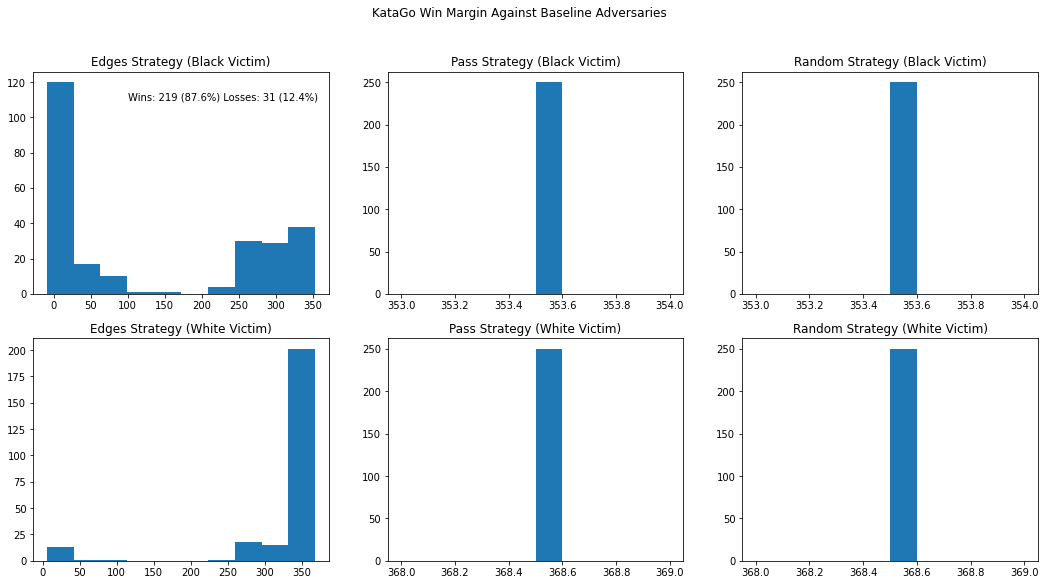

In [3]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(18, 9)

for i, strat in enumerate(("Edges", "Pass", "Random")):
    black = [
        game.score()[sente.stone.BLACK] - game.score()[sente.stone.WHITE]
        for game in games[f'{strat.lower()}-black']
    ]
    white = [
        game.score()[sente.stone.WHITE] - game.score()[sente.stone.BLACK]
        for game in games[f'{strat.lower()}-white']
    ]

    if strat == "Edges":
        black_wins = sum(black > 0 for black in black)
        white_wins = sum(white > 0 for white in white)
        black_losses = sum(black < 0 for black in black)
        white_losses = sum(white < 0 for white in white)
        black_draws = sum(black == 0 for black in black)
        white_draws = sum(white == 0 for white in white)

        ax[0, i].text(100, 110, f"Wins: {black_wins} ({100 * black_wins / 250:.1f}%) Losses: {black_losses} ({100 * black_losses / 250:.1f}%)")
    
    ax[0, i].hist(black)
    ax[1, i].hist(white)
    ax[0, i].set_title(f'{strat} Strategy (Black Victim)')
    ax[1, i].set_title(f'{strat} Strategy (White Victim)')

fig.suptitle("KataGo Win Margin Against Baseline Adversaries")

Text(0.5, 0.98, 'KataGo Adversarial Win Margin vs. Length of Game')

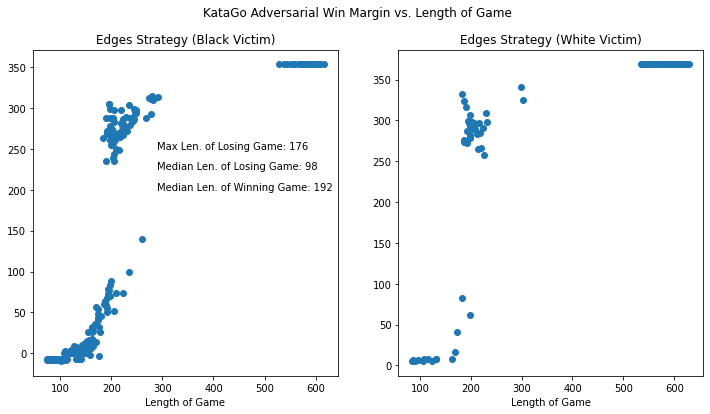

In [4]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 6)

black = [
    game.score()[sente.stone.BLACK] - game.score()[sente.stone.WHITE]
    for game in games[f'edges-black']
]
white = [
    game.score()[sente.stone.WHITE] - game.score()[sente.stone.BLACK]
    for game in games[f'edges-white']
]
black_length = [len(game.get_current_sequence()) for game in games[f'edges-black']]
white_length = [len(game.get_current_sequence()) for game in games[f'edges-white']]
losing_lengths = [l for l, s in zip(black_length, black) if s < 0]
winning_lengths = [l for l, s in zip(black_length, black) if s > 0]

ax[0].scatter(black_length, black)
ax[1].scatter(white_length, white)
ax[0].text(290, 250, f"Max Len. of Losing Game: {max(losing_lengths)}")
ax[0].text(290, 225, f"Median Len. of Losing Game: {np.median(losing_lengths):.0f}")
ax[0].text(290, 200, f"Median Len. of Winning Game: {np.median(winning_lengths):.0f}")
ax[0].set_title('Edges Strategy (Black Victim)')
ax[1].set_title('Edges Strategy (White Victim)')
ax[0].set_xlabel('Length of Game')
ax[1].set_xlabel('Length of Game')

fig.suptitle("KataGo Adversarial Win Margin vs. Length of Game")

In [6]:
losing_games = [
    game
    for game in games[f'edges-black']
    if game.score()[sente.stone.BLACK] - game.score()[sente.stone.WHITE] < 0
]
print(losing_games[0])

 1  .  .  .  .  ⚪ ⚪ ⚪ .  ⚪ ⚪ .  .  ⚪ .  .  ⚪ ⚪ ⚪ ⚪
 2  .  .  .  .  .  ⚫ .  ⚫ .  ⚫ .  .  .  ⚫ ⚫ .  .  .  ⚪
 3  .  .  ⚫ .  .  ⚫ .  .  .  .  .  .  ⚫ .  .  ⚫ ⚫ .  ⚪
 4  ⚪ .  .  ⚫ .  .  .  .  .  ⚫ .  .  .  .  .  *  .  .  ⚪
 5  ⚪ .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  ⚫ .  ⚪
 6  .  ⚫ .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  ⚪
 7  ⚪ .  ⚫ .  .  .  .  .  .  .  .  .  .  .  .  .  ⚫ .  ⚪
 8  ⚪ .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  ⚫ .  ⚪
 9  ⚪ .  ⚫ .  .  .  .  .  .  ⚫ .  .  .  .  .  ⚫ .  .  ⚪
10  ⚪ .  .  *  .  .  .  .  .  *  .  .  .  .  .  *  ⚫ .  ⚪
11  .  ⚫ .  .  .  .  .  .  .  ⚫ .  .  .  .  .  .  ⚫ .  ⚪
12  ⚪ ⚫ .  ⚫ .  .  .  .  .  .  .  .  .  .  .  .  .  .  ⚪
13  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  ⚫ .  .
14  ⚪ .  ⚫ .  .  .  .  .  .  .  .  .  .  .  .  .  .  ⚫ ⚪
15  ⚪ .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  ⚫ .
16  .  .  .  ⚫ .  .  ⚫ .  .  *  .  .  .  .  .  ⚫ ⚫ ⚫ ⚪
17  ⚪ .  ⚫ .  .  ⚫ .  ⚫ .  ⚫ .  ⚫ .  ⚫ .  .  .  .  ⚪
18  ⚪ .  ⚫ ⚫ .  .  .  ⚫ .  .  .  .  .  ⚫

In [8]:
sente.sgf.dump(losing_games[0], str(Path.home() / "losing-game.sgf"))